# Regressão Linear Múltipla

## Objetivo
Com este código, você irá:
- Estender o nosso modelo de regressão para que ele possa contemplar múltiplas características
    - Vamos estender a estrutura dos dados para contemplar múltiplas características
    - Reescrever a previsão, a função custo e o cálculo do gradiente para contemplar a possibilidade de múltiplas características
    - Utilizar a função `np.dot` para vetorizar nossa implementação, para simplificar o código e torná-lo mais rápido.

In [1]:
import copy, math
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision=2)  # reduz a precisão das numpy arrays na hora de dar print

# Definição do Problema

Usaremos um exemplo de motivação baseado no problema de estimar o preço de uma casa.

Os dados de treinamento contêm três exemplos com quatro características (size, bedrooms, floors e age).  Note que a primeira característica possui uma ordem de grandeza muito maior que as demais. Isso causará um problema, mas nós resolveremos isso em códigos futuros. 


| Size (sqft) | Number of Bedrooms  | Number of floors | Age of  Home | Price (1000s dollars)  |   
| ----------------| ------------------- |----------------- |--------------|-------------- |  
| 2104            | 5                   | 1                | 45           | 460           |  
| 1416            | 3                   | 2                | 40           | 232           |  
| 852             | 2                   | 1                | 35           | 178           |  

Você irá construir um modelo de regressão linear usando esses valores de tal forma que você também possa depois estimar o preço de outras casas. Por exemplo, um casa com 1200 sqft, 3 bedrooms, 1 floor, 40 years old.  


In [2]:
X_train = np.array([[2104, 5, 1, 45], [1416, 3, 2, 40], [852, 2, 1, 35]])
y_train = np.array([460, 232, 178])

## Dando print na nossa matriz X, que contém nossos exemplos de treinamento

In [3]:
print(f"X Shape: {X_train.shape}, X Type:{type(X_train)})")
print(X_train)
print(f"y Shape: {y_train.shape}, y Type:{type(y_train)})")
print(y_train)

X Shape: (3, 4), X Type:<class 'numpy.ndarray'>)
[[2104    5    1   45]
 [1416    3    2   40]
 [ 852    2    1   35]]
y Shape: (3,), y Type:<class 'numpy.ndarray'>)
[460 232 178]


## Parâmetros $w$ e $b$

* $\mathbf{w}$ é um vetor com $n$ elementos.
  - Cada elemento contém um parâmetro associado a uma característica
  - Para o nosso conjunto de dados, $n$ é 4 (número de características)
  - $b$ é um parâmetro escalar (apenas um único número)


Para demonstração, $\mathbf{w}$ e $b$ serão carregados com um valor inicial que é próximo do ótimo. $\mathbf{w}$ é um vetor construído como sendo uma numpy array de 1 dimensão (1-D NumPy array).

In [4]:
b_init = 785.1811367994083
w_init = np.array([ 0.39133535, 18.75376741, -53.36032453, -26.42131618])
print(f"w_init shape: {w_init.shape}, b_init type: {type(b_init)}")

w_init shape: (4,), b_init type: <class 'float'>


# Previsão usando o Modelo com múltiplas características

A previsão do modelo com múltiplas características é dada pelo seguinte modelo linear:

$$ f_{\mathbf{w},b}(\mathbf{x}) =  w_0x_0 + w_1x_1 +... + w_{n-1}x_{n-1} + b \tag{1}$$

ou, usando uma notação vetorial:

$$ f_{\mathbf{w},b}(\mathbf{x}) = \mathbf{w} \cdot \mathbf{x} + b  \tag{2} $$ 

onde $\cdot$ é o produtor escalar (`dot product`)

Para demonstrar o produto escalar, iremos implementar a previsão usando (1) e (2).


## Usando (1) e um loop for


In [5]:
def previsao_usando_loop_for(x, w, b): 
    """
    faz uma previsão usando loop for
    
    Args:
      x (ndarray): Shape (n,) -> exemplo contendo múltiplas características
      w (ndarray): Shape (n,) -> parâmetros w do modelo
      b (scalar):  parâmetro b do modelo
      
    retorna:
      p (scalar):  previsão
    """
    n = x.shape[0]
    p = 0
    for i in range(n):
        p_i = x[i] * w[i]  
        p = p + p_i         
    p = p + b                
    return p

In [6]:
# pegando uma linha do nosso conjunto de dados
x_vec = X_train[0,:]
print(f"x_vec shape {x_vec.shape}, x_vec: {x_vec}")

# fazendo previsão para essa casa
f_wb = previsao_usando_loop_for(x_vec, w_init, b_init)
print(f"f_wb shape {f_wb.shape}, previsão: {f_wb}")

x_vec shape (4,), x_vec: [2104    5    1   45]
f_wb shape (), previsão: 459.9999976194083


Note que o shape do `x_vec` é 1-D NumPy vector com 4 elementos, ou seja, (4,). Já o resultado da previsão, `f_wb`, é um escalar.


## Usando (2) e o produto escalar para termos uma versão vetorizada

In [7]:
def previsao(x, w, b): 
    """
    Args:
      x (ndarray): Shape (n,) -> exemplo contendo múltiplas características
      w (ndarray): Shape (n,) -> parâmetros w do modelo
      b (scalar):  parâmetro b do modelo
      
    retorna:
      p (scalar):  previsão
    """
    p = np.dot(x, w) + b     
    return p    

In [8]:
# pegando uma linha do nosso conjunto de dados
x_vec = X_train[0,:]
print(f"x_vec shape {x_vec.shape}, x_vec: {x_vec}")

# fazendo previsão para essa casa
f_wb = previsao(x_vec, w_init, b_init)
print(f"f_wb shape {f_wb.shape}, previsão: {f_wb}")

x_vec shape (4,), x_vec: [2104    5    1   45]
f_wb shape (), previsão: 459.9999976194083


# Calculando o custo quando o modelo possui múltiplas características
A função custo $J(\mathbf{w},b)$ quando temos múltiplas características é dada por:
$$J(\mathbf{w},b) = \frac{1}{2m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})^2 \tag{3}$$ 
onde:
$$ f_{\mathbf{w},b}(\mathbf{x}^{(i)}) = \mathbf{w} \cdot \mathbf{x}^{(i)} + b  \tag{4} $$ 


Diferentemente dos nossos códigos anteriores, agora $\mathbf{w}$ e $\mathbf{x}^{(i)}$ são vetores ao invés de escalares.

Abaixo encontram-se uma implementação das equações (3) and (4).

In [9]:
def calcula_custo(X, y, w, b): 
    """
    Calcula o custo
    Args:
      X (ndarray (m,n)): Dados, contendo m exemplos com n características
      y (ndarray (m,)) : valores alvo
      w (ndarray (n,)) : parâmetros w do modelo  
      b (scalar)       : parâmetro b do modelo
      
    Retorna:
      custo (escalar): custo
    """
    m     = X.shape[0]
    custo = 0.0
    for i in range(m):                                
        f_wb_i = np.dot(X[i], w) + b           #(n,)(n,) = escalar (see np.dot)
        custo = custo + (f_wb_i - y[i])**2     # escalar
    custo = custo / (2 * m)                    # escalar    
    return custo

In [10]:
# Calcula e mostra o custo usando os nossos parâmetros ótimos escolhidos previamente 
custo = calcula_custo(X_train, y_train, w_init, b_init)
print(f'Custo com parâmetros ótimos: {custo}')

Custo com parâmetros ótimos: 1.5578904428966628e-12


**Resultado esperado**: 1.5578904045996674e-12

# Método do Gradiente com Múltiplas Variáveis

Método do Gradiente com Múltiplas Variáveis:

$$\begin{align*} \text{repetir}&\text{ até convergir:} \; \lbrace \newline\;
& w_j = w_j -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial w_j} \tag{5}  \; & \text{para j = 0..n-1}\newline
&b\ \ = b -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial b}  \newline \rbrace
\end{align*}$$

onde, n é o número de características, parâmetros $w_j$ e $b$ são atualizados simultaneamente e onde  

$$
\begin{align}
\frac{\partial J(\mathbf{w},b)}{\partial w_j}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})x_{j}^{(i)} \tag{6}  \\
\frac{\partial J(\mathbf{w},b)}{\partial b}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)}) \tag{7}
\end{align}
$$
* m é o número de amostras de treinamento no nosso conjunto de dados

    
*  $f_{\mathbf{w},b}(\mathbf{x}^{(i)})$ é a previsão feita pelo modelo, enquanto que $y^{(i)}$ é o valor alvo


## Calculando o gradiente

Abaixo encontra-se uma implementação para calcular as equações (6) e (7). Existe muitas formas para se implementar isso. Certifique-se que você compreendeu a implementação.
   

In [11]:
def calcula_gradiente(X, y, w, b): 
    """
    Calcula Gradiente para Regressão Linear
    Args:
      X (ndarray (m,n)): Dados, contendo m exemplos com n características
      y (ndarray (m,)) : valores alvo
      w (ndarray (n,)) : parâmetros w do modelo  
      b (scalar)       : parâmetro b do modelo
      
    Retorna:
      dj_dw (ndarray (n,)): O gradiente da função custo com relação aos parâmetros w. 
      dj_db (escalar):      O gradiente da função custo com relação ao parâmetro b. 
    """
    m,n = X.shape           #(número de exemplos, número de características)
    dj_dw = np.zeros((n,))
    dj_db = 0.

    for i in range(m):                             
        erro = (np.dot(X[i], w) + b) - y[i]   
        for j in range(n):                         
            dj_dw[j] = dj_dw[j] + erro * X[i, j]    
        dj_db = dj_db + erro                        
    dj_dw = dj_dw / m                                
    dj_db = dj_db / m                                
        
    return dj_db, dj_dw

In [12]:
# Calcula e mostra o gradiente
tmp_dj_db, tmp_dj_dw = calcula_gradiente(X_train, y_train, w_init, b_init)
print(f'dj_db com valores iniciais para w,b: {tmp_dj_db}')
print(f'dj_dw com valores iniciais para w,b: \n {tmp_dj_dw}')

dj_db com valores iniciais para w,b: -1.6739251501955248e-06
dj_dw com valores iniciais para w,b: 
 [-2.73e-03 -6.27e-06 -2.22e-06 -6.92e-05]


**Resultados Esperados**:   
dj_db com valores iniciais w,b: -1.6739251122999121e-06  
dj_dw com valores iniciais w,b:   
 [-2.73e-03 -6.27e-06 -2.22e-06 -6.92e-05]  

## Método do Gradiente com múltiplas características

A rotina a seguir implementa a equação (5)

In [13]:
def metodo_do_gradiente(X, y, w_in, b_in, calcula_custo, calcula_gradiente, alpha, num_iters): 
    """
    Performa Método do Gradiente para aprender w e b. Atualiza w e b ao longo de  
    num_iters passos de iteração usando uma taxa de aprendizado alpha
    
    Args:
      X (ndarray (m,n))   : Dados, contendo m exemplos com n características
      y (ndarray (m,))    : valores alvo
      w_in (ndarray (n,)) : valores iniciais dos parâmetros w do modelo  
      b_in (escalar)      : valor inicial do parâmetro b do modelo
      calcula_custo       : função que calcula o custo
      calcula_gradiente   : função que calcula o gradiente
      alpha (float)       : taxa de aprendizado
      num_iters (int)     : Número de iterações para o método do gradiente
      
    Retorna:
      w (ndarray (n,)) : Valores atualizados para os parâmetros w
      b (scalar)       : Valores atualizado para o parâmetro b 
      """
    
    # Valores históricos
    J_history = []
    w = w_in
    b = b_in
    
    for i in range(num_iters):

        # Calcula o gradiente
        dj_db,dj_dw = calcula_gradiente(X, y, w, b)  

        # Atualiza os parâmetros
        w = w - alpha * dj_dw               
        b = b - alpha * dj_db              
      
        # Salva o custo
        if i<100000:      # prevent resource exhaustion 
            J_history.append( calcula_custo(X, y, w, b))

        # Faz print de tempos em tempos
        if i% math.ceil(num_iters / 10) == 0:
            print(f"Iteração {i:4d}: Custo {J_history[-1]:8.2f}   ")
        
    return w, b, J_history # retorna valores finais e históricos

Na célula a seguir testamos a implementação

In [14]:
# inicializando parâmetros
initial_w = np.zeros_like(w_init)
initial_b = 0.
# parâmetros para rodar o Método do Gradiente:
iterations = 1000
alpha      = 5.0e-7
# Rodando o Método do gradiente 
w_final, b_final, J_hist = metodo_do_gradiente(X_train, y_train, initial_w, initial_b,
                                                    calcula_custo, calcula_gradiente, 
                                                    alpha, iterations)
print(f"b,w encontrados pelo método do gradiente: {b_final:0.2f},{w_final} ")
m,_ = X_train.shape
for i in range(m):
    print(f"previsão: {np.dot(X_train[i], w_final) + b_final:0.2f}, valor alvo: {y_train[i]}")

Iteração    0: Custo  2529.46   
Iteração  100: Custo   695.99   
Iteração  200: Custo   694.92   
Iteração  300: Custo   693.86   
Iteração  400: Custo   692.81   
Iteração  500: Custo   691.77   
Iteração  600: Custo   690.73   
Iteração  700: Custo   689.71   
Iteração  800: Custo   688.70   
Iteração  900: Custo   687.69   
b,w encontrados pelo método do gradiente: -0.00,[ 0.2   0.   -0.01 -0.07] 
previsão: 426.19, valor alvo: 460
previsão: 286.17, valor alvo: 232
previsão: 171.47, valor alvo: 178


**Resultados Esperados**:    
b,w encotrados pelo método do gradiente: -0.00,[ 0.2   0.   -0.01 -0.07]   
previsão: 426.19, valor alvo: 460  
previsão: 286.17, valor alvo: 232  
previsão: 171.47, valor alvo: 178  

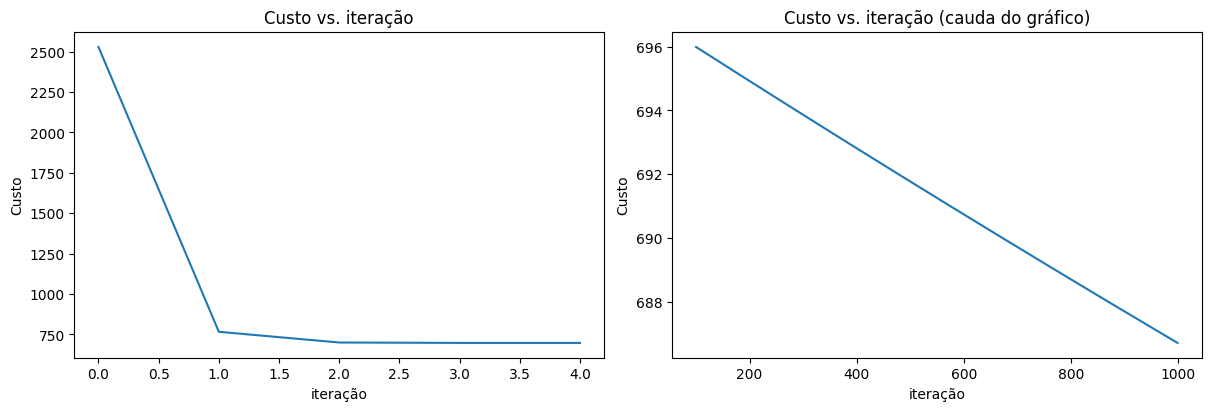

In [23]:
# Plotando os resultados
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 4))
ax1.plot(J_hist[0:5])
ax2.plot(100 + np.arange(len(J_hist[100:])), J_hist[100:])
ax1.set_title("Custo vs. iteração");  ax2.set_title("Custo vs. iteração (cauda do gráfico)")
ax1.set_ylabel('Custo')             ;  ax2.set_ylabel('Custo') 
ax1.set_xlabel('iteração')   ;  ax2.set_xlabel('iteração') 
plt.show()

*Estes resultados ainda não são os melhores*! O custo ainda está caindo e nossas previsões não estão tão precisas. No próximo código nós vamos descobrir como melhorar isso.

# Parabéns!
Com este código você:
- Redesenvolveu as rotinas para Regressão Linear, agora com múltiplas variáveis.
- Utilizou NumPy `np.dot` para vetorizar as implementações